In [2]:
##Importing seaborn, numpy, pandas, matplotlib ##MS4 START HERE
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
DATA="/content/drive/MyDrive/data_MS2"
#read the csv
games = pd.read_csv(f"{DATA}/games.csv")
users = pd.read_csv(f"{DATA}/users.csv")
recs = pd.read_csv(f"{DATA}/recommendations.csv")

pd.set_option('display.max_columns', None)
display(games)
display(users)
display(recs)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,2296380,I Expect You To Die 3: Cog in the Machine,2023-09-28,True,False,False,Very Positive,96,101,22.00,0.00,0.0,True
50868,1272080,PAYDAY 3,2023-09-21,True,False,False,Mostly Negative,38,29458,40.00,0.00,0.0,True
50869,1402110,Eternights,2023-09-11,True,False,False,Very Positive,89,1128,30.00,0.00,0.0,True
50870,2272250,Forgive Me Father 2,2023-10-19,True,False,False,Very Positive,95,82,17.00,0.00,0.0,True


,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2
...,...,...,...
14306059,5047430,6,0
14306060,5048153,0,0
14306061,5059205,31,0
14306062,5074363,0,0


,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4
...,...,...,...,...,...,...,...,...
41154789,633230,0,0,2021-02-15,True,41.0,1606890,41154789
41154790,758870,8,0,2019-07-18,False,8.0,1786254,41154790
41154791,696170,3,10,2018-03-26,False,2.0,6370324,41154791
41154792,696170,0,0,2018-06-11,True,4.0,1044289,41154792


In [3]:
def safe_bool_to01(s):
    return (s.astype(str).str.strip().str.lower()
            .map({"true":1,"1":1,"yes":1,"false":0,"0":0,"no":0}))

In [4]:
def gram_schmidt(v, V):
    """Orthogonalize vector v against existing columns in V (shape d×m)."""
    if V is None or V.size == 0:
        return v
    for j in range(V.shape[1]):
        proj = np.dot(v, V[:, j]) * V[:, j]
        v = v - proj
    return v

In [5]:
def power_iter_matvec(R, v, num_iter=200, tol=1e-6):
    """
    Power iteration for R^T R via matvecs:
      w = R v
      u = w / ||w||      (left singular direction)
      v' = R^T u; normalize
    Returns (v_unit, u_unit, sigma)
    """
    v = v.astype(np.float32, copy=False)
    v = v / (np.linalg.norm(v) + 1e-12)
    last = v
    for _ in range(num_iter):
        w = R @ v             # (n,)
        sigma = np.linalg.norm(w).astype(np.float64)
        if sigma == 0:
            return last, np.zeros_like(w), 0.0
        u = (w / sigma).astype(np.float32)
        v_new = R.T @ u       # (d,)
        vn = np.linalg.norm(v_new).astype(np.float64)
        if vn == 0:
            return last, u, float(sigma)
        v_new = (v_new / vn).astype(np.float32)
        if np.linalg.norm(v_new - last) < tol:
            v = v_new
            break
        last = v
        v = v_new
    # recompute clean outputs
    w = R @ v
    sigma = float(np.linalg.norm(w))
    if sigma == 0:
        return v, np.zeros_like(w), 0.0
    u = (w / sigma).astype(np.float32)
    return v, u, sigma

In [6]:
def svd_power_memsafe(R, k=10, num_iter=200, seed=42):
    """
    Top-k SVD of R (n×d) using RAM-safe power iteration:
    - No forming C=R^T R
    - No full-matrix deflation
    - Orthogonalize each right singular vector v against previous Vs
    Returns U (n,k), S (k,), Vt (k,d)
    """
    rng = np.random.default_rng(seed)
    n, d = R.shape
    V = np.zeros((d, k), dtype=np.float32)
    U = np.zeros((n, k), dtype=np.float32)
    S = np.zeros(k, dtype=np.float32)

    V_prev = None
    for i in range(k):
        v0 = rng.normal(size=d).astype(np.float32)
        # orthogonalize init to previous
        v0 = gram_schmidt(v0, V_prev)
        if np.linalg.norm(v0) == 0:
            v0 = rng.normal(size=d).astype(np.float32)
        v0 = v0 / (np.linalg.norm(v0) + 1e-12)

        v = v0
        # iterate with re-orthogonalization each step
        last = v
        for _ in range(num_iter):
            # matvec power step
            w = R @ v
            sigma = np.linalg.norm(w).astype(np.float64)
            if sigma == 0:
                u = np.zeros_like(w)
                break
            u = (w / sigma).astype(np.float32)
            v_new = R.T @ u
            # Gram-Schmidt against previous vectors
            v_new = gram_schmidt(v_new, V_prev)
            vn = np.linalg.norm(v_new).astype(np.float64)
            if vn == 0:
                v_new = rng.normal(size=d).astype(np.float32)
                v_new = gram_schmidt(v_new, V_prev)
                vn = np.linalg.norm(v_new).astype(np.float64)
            v_new = (v_new / (vn + 1e-12)).astype(np.float32)
            if np.linalg.norm(v_new - last) < 1e-6:
                v = v_new
                break
            last = v
            v = v_new
        # finalize this component
        w = R @ v
        sigma = float(np.linalg.norm(w))
        u = (w / (sigma + 1e-12)).astype(np.float32) if sigma > 0 else np.zeros(n, dtype=np.float32)

        V[:, i] = v
        U[:, i] = u
        S[i] = sigma
        # update V_prev matrix
        V_prev = V[:, :i+1]

    return U, S.astype(np.float32), V.T.astype(np.float32)

In [7]:
def pca_power(Z, n_components):
    """PCA via custom, RAM-safe SVD on standardized Z."""
    U, S, Vt = svd_power_memsafe(Z, k=n_components)
    total_var = float((S.astype(np.float64)**2).sum())
    Xp = (U * S).astype(np.float32)
    evr = (S**2)/total_var if total_var>0 else np.zeros_like(S, dtype=np.float32)
    return Xp, evr, Vt.T  # (n,k), (k,), (d,k)

In [8]:
def kmeans_pp_init(X, k, rng):
    n = X.shape[0]
    C = np.empty((k, X.shape[1]), dtype=X.dtype)
    C[0] = X[rng.integers(0, n)]
    d2 = np.full(n, np.inf, dtype=np.float64)
    for i in range(1, k):
        diff = X - C[i-1]
        d2 = np.minimum(d2, np.einsum('ij,ij->i', diff, diff))
        probs = d2 / d2.sum()
        C[i] = X[rng.choice(n, p=probs)]
    return C

In [9]:
def kmeans_numpy(X, k, iters=200, seed=42, tol=1e-5):
    rng = np.random.default_rng(seed)
    C = kmeans_pp_init(X, k, rng)
    for _ in range(iters):
        dists = ((X[:,None,:] - C[None,:,:])**2).sum(axis=2)
        lab = dists.argmin(axis=1)
        newC = np.vstack([
            X[lab==j].mean(axis=0) if np.any(lab==j) else C[j]
            for j in range(k)
        ])
        if np.allclose(newC, C, atol=tol):
            C = newC; break
        C = newC
    inertia = float(((X - C[lab])**2).sum())
    return lab, C, inertia

In [10]:
def silhouette_sample(X, labels, sample_size=2000, seed=42):
    n = X.shape[0]
    if n <= 2 or len(np.unique(labels)) < 2: return np.nan
    rng = np.random.default_rng(seed)
    idx = rng.choice(n, size=min(sample_size, n), replace=False)
    Xs, ls = X[idx], labels[idx]
    m = Xs.shape[0]; sil = np.zeros(m, dtype=np.float32)
    classes = np.unique(ls)
    for i in range(m):
        xi = Xs[i]
        same = (ls == ls[i])
        if same.sum() > 1:
            d_same = np.sqrt(((Xs[same] - xi)**2).sum(axis=1))
            a = d_same[d_same>0].mean() if (d_same>0).any() else 0.0
        else: a = 0.0
        b = np.inf
        for c in classes:
            if c == ls[i]: continue
            grp = Xs[ls==c]
            if grp.shape[0]==0: continue
            di = np.sqrt(((grp - xi)**2).sum(axis=1)).mean()
            if di < b: b = di
        sil[i] = 0.0 if max(a,b)==0 else (b-a)/max(a,b)
    return float(np.nanmean(sil))

In [11]:
def adjusted_rand_index(y_true, y_pred):
    """ARI via contingency table (overflow-safe, float64 math)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    classes, class_idx = np.unique(y_true, return_inverse=True)
    clusters, cluster_idx = np.unique(y_pred, return_inverse=True)
    n = float(y_true.size)

    # contingency (int64 counts are fine)
    cont = np.zeros((classes.size, clusters.size), dtype=np.int64)
    for i in range(int(n)):
        cont[class_idx[i], cluster_idx[i]] += 1

    # cast to float64 BEFORE products to avoid overflow
    cont_f = cont.astype(np.float64)
    a = cont_f.sum(axis=1)  # row sums
    b = cont_f.sum(axis=0)  # col sums

    # combinations in float
    sum_comb = (cont_f * (cont_f - 1.0) / 2.0).sum()
    sum_a    = (a * (a - 1.0) / 2.0).sum()
    sum_b    = (b * (b - 1.0) / 2.0).sum()

    total = n * (n - 1.0) / 2.0
    if total <= 0:
        return 0.0

    expected = (sum_a * sum_b) / total
    max_index = 0.5 * (sum_a + sum_b)
    denom = max_index - expected

    # guard against tiny/negative denominator due to rounding
    if np.isclose(denom, 0.0):
        return 0.0

    ari = (sum_comb - expected) / denom
    # clamp tiny numerical noise
    if np.isnan(ari) or np.isinf(ari):
        return 0.0
    return float(ari)

In [12]:
def normalized_mutual_info(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    c_vals, ci = np.unique(y_true, return_inverse=True)
    k_vals, ki = np.unique(y_pred, return_inverse=True)
    n = len(y_true)
    cont = np.zeros((c_vals.size, k_vals.size), dtype=np.int64)
    for i in range(n): cont[ci[i], ki[i]] += 1
    P = cont/n; Pc = P.sum(axis=1, keepdims=True); Pk = P.sum(axis=0, keepdims=True)
    def H(p): p=p[p>0]; return -float((p*np.log(p)).sum()) if p.size else 0.0
    Hc, Hk = H(Pc.flatten()), H(Pk.flatten())
    mask = P>0
    MI = float((P[mask]*(np.log(P[mask])-np.log((Pc@Pk)[mask]))).sum())
    denom=(Hc+Hk)/2.0
    return 0.0 if denom==0 else MI/denom

In [13]:
# Clean & type
recs["helpful"] = pd.to_numeric(recs["helpful"], errors="coerce", downcast="integer")
recs["funny"]   = pd.to_numeric(recs["funny"],   errors="coerce", downcast="integer")
recs["hours"]   = pd.to_numeric(recs["hours"],   errors="coerce", downcast="float")
recs["date"]    = pd.to_datetime(recs["date"], errors="coerce")
recs["is_recommended"] = safe_bool_to01(recs["is_recommended"]).fillna(0).astype("int8")

if "user_id" in users:
    # downcast some user numerics if present
    for c in ["account_age","num_friends"]:
        if c in users: users[c] = pd.to_numeric(users[c], errors="coerce", downcast="integer")
    recs = recs.merge(users, on="user_id", how="left")

if "app_id" in games:
    g = games.copy()
    if "date_release" in g: g["date_release"] = pd.to_datetime(g["date_release"], errors="coerce")
    for b in ["win","mac","linux"]:
        if b in g: g[b] = safe_bool_to01(g[b]).fillna(0).astype("int8")
    for c in ["price_final","positive_ratio"]:
        if c in g: g[c] = pd.to_numeric(g[c], errors="coerce")
    recs = recs.merge(g, on="app_id", how="left")

In [14]:
# ---------- Feature Engineering ----------
df = recs
df["log_hours"]        = np.log1p(df["hours"]).astype("float32")
df["log_helpful"]      = np.log1p(df["helpful"]).astype("float32")
df["log_funny"]        = np.log1p(df["funny"]).astype("float32")
df["helpful_per_hour"] = (df["helpful"]/(1+df["hours"])).astype("float32")
df["funny_per_hour"]   = (df["funny"]  /(1+df["hours"])).astype("float32")
df["hf_interact"]      = (df["helpful"]*df["funny"]).astype("float32")
if "date" in df:
    md = df["date"].max()
    df["recency_days"] = (md - df["date"]).dt.days.astype("float32")
    df["year"]  = df["date"].dt.year.astype("int16")
    df["month"] = df["date"].dt.month.astype("int8")
    df["dow"]   = df["date"].dt.dayofweek.astype("int8")
if "date_release" in df and "date" in df:
    df["game_age_days"] = (df["date"] - df["date_release"]).dt.days.astype("float32")

In [15]:
# ---------- Build X, y with memory-lean encoding ----------
y = df["is_recommended"].astype("int8")
drop_cols = [c for c in ["is_recommended","date","date_release","user_id","app_id"] if c in df]
X = df.drop(columns=drop_cols, errors="ignore")

# Frequency-encode big categoricals; one-hot only small ones
obj_cols = [c for c in X.columns if X[c].dtype == "object"]
small_ohe, freq_cols = [], []
for c in obj_cols:
    nun = X[c].nunique(dropna=True)
    if nun <= 30: small_ohe.append(c)
    else:         freq_cols.append(c)

for c in freq_cols:
    vc = X[c].value_counts(normalize=True)
    X[c] = X[c].map(vc).fillna(0).astype("float32")

if small_ohe:
    X = pd.get_dummies(X, columns=small_ohe, drop_first=False)

# Fill NA & downcast numerics
for c in X.columns:
    if pd.api.types.is_numeric_dtype(X[c]):
        X[c] = X[c].fillna(X[c].median()).astype("float32")

In [16]:
# ---------- PCA + KMeans (RAM-safe SVD) ----------
results = []
best = None

Xn = X.to_numpy(dtype=np.float32, copy=False)
mu = Xn.mean(axis=0); sd = Xn.std(axis=0); sd[sd==0]=1.0
Z  = (Xn - mu)/sd

N_COMP_LIST = [2, 5]   # keep modest to save time/RAM
K_LIST = [2, 3, 4, 5, 6]

best = None
for nc in N_COMP_LIST:
    print(f"[INFO] Running PCA with n_components={nc}...")
    Xp, evr, _ = pca_power(Z, n_components=nc)
    for k in K_LIST:
        print(f"   → Clustering with k={k} ...", end=" ")
        labels, centers, inertia = kmeans_numpy(Xp, k, iters=200, seed=42)
        sil = silhouette_sample(Xp, labels, sample_size=min(1500, len(labels)), seed=42)
        ari = adjusted_rand_index(y, labels)
        nmi = normalized_mutual_info(y, labels)
        score = np.nan_to_num(sil)+0.5*np.nan_to_num(ari)+0.5*np.nan_to_num(nmi)
        metrics = {"silhouette":sil,"ARI":ari,"NMI":nmi,"explained_var":float(evr.sum())}
        results.append((nc, k, float(inertia), metrics))
        if (best is None) or (score>best[0]):
            best=(score,nc,k,labels,Xp,inertia,metrics)
        print("done.")

[INFO] Running PCA with n_components=2...
   → Clustering with k=2 ... done.
   → Clustering with k=3 ... done.
   → Clustering with k=4 ... done.
   → Clustering with k=5 ... done.
   → Clustering with k=6 ... done.
[INFO] Running PCA with n_components=5...
   → Clustering with k=2 ... done.
   → Clustering with k=3 ... done.
   → Clustering with k=4 ... done.
   → Clustering with k=5 ... done.
   → Clustering with k=6 ... done.


In [17]:
# ---------- Report ----------
_, best_nc, best_k, best_labels, Xp_best, inertia, m = best
print("=== PCA (custom RAM-safe SVD) + KMeans ===")
print(f"n_components = {best_nc}, k = {best_k}")
print(f"Explained variance = {m['explained_var']:.4f}")
print(f"Inertia = {inertia:.2f}")
print(f"Silhouette = {m['silhouette']:.4f}")
print(f"ARI = {m['ARI']:.4f} | NMI = {m['NMI']:.4f}")

=== PCA (custom RAM-safe SVD) + KMeans ===
n_components = 2, k = 4
Explained variance = 1.0000
Inertia = 109914512.00
Silhouette = 0.4139
ARI = 0.0423 | NMI = 0.0316


In [18]:
# Crosstab clusters vs labels
ct = pd.crosstab(pd.Series(best_labels, name="cluster"),
                 pd.Series(y,            name="is_recommended"))
print("\nCluster vs. is_recommended:\n", ct)


Cluster vs. is_recommended:
 is_recommended        0         1
cluster                          
0                794743   8686379
1               2732077   6910652
2               2321869  19701939
3                  1707      5428


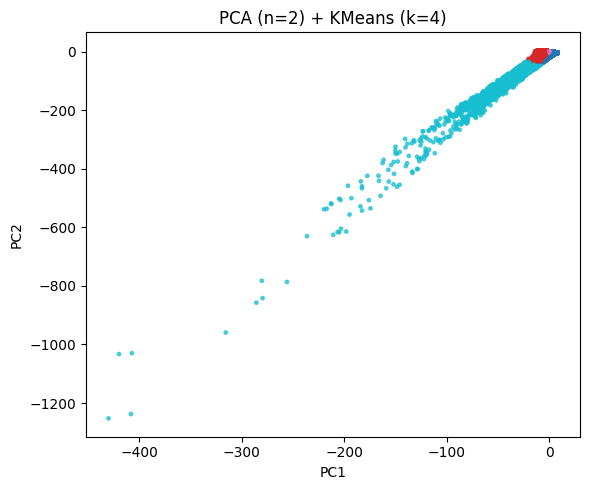

In [19]:
# 2D plot when possible
if Xp_best.shape[1] >= 2:
    plt.figure(figsize=(6,5))
    plt.scatter(Xp_best[:,0], Xp_best[:,1], c=best_labels, s=6, cmap="tab10", alpha=0.7)
    plt.title(f"PCA (n={best_nc}) + KMeans (k={best_k})")
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

In [20]:
# ---------- Comparison Table ----------
df_results = pd.DataFrame([
    {
        "n_components": nc,
        "k": k,
        "explained_var": m["explained_var"],
        "silhouette": m["silhouette"],
        "ARI": m["ARI"],
        "NMI": m["NMI"],
        "inertia": inertia
    }
    for (nc, k, inertia, m) in results
])

print("\n=== PCA + KMeans Results (all runs) ===")
print(df_results.round(4).to_string(index=False))


=== PCA + KMeans Results (all runs) ===
 n_components  k  explained_var  silhouette     ARI    NMI     inertia
            2  2            1.0      0.4276  0.0061 0.0236 172457664.0
            2  3            1.0      0.4094  0.0443 0.0324 146201920.0
            2  4            1.0      0.4139  0.0423 0.0316 109914512.0
            2  5            1.0      0.4162  0.0379 0.0294  87223264.0
            2  6            1.0      0.3850  0.0302 0.0300  76025248.0
            5  2            1.0      0.1915 -0.0158 0.0191 431796992.0
            5  3            1.0      0.2056  0.0022 0.0118 377256896.0
            5  4            1.0      0.2440  0.0324 0.0336 322164960.0
            5  5            1.0      0.2685  0.0210 0.0324 281349216.0
            5  6            1.0      0.2724  0.0209 0.0324 241754256.0


In [21]:
# Show results neatly
print("\n=== PCA + KMeans Results (all runs) ===")
display(df_results.round(4).style.set_caption("PCA+KMeans Metrics"))


=== PCA + KMeans Results (all runs) ===


,n_components,k,explained_var,silhouette,ARI,NMI,inertia
0,2,2,1.000000,0.427600,0.006100,0.023600,172457664.000000
1,2,3,1.000000,0.409400,0.044300,0.032400,146201920.000000
2,2,4,1.000000,0.413900,0.042300,0.031600,109914512.000000
3,2,5,1.000000,0.416200,0.037900,0.029400,87223264.000000
4,2,6,1.000000,0.385000,0.030200,0.030000,76025248.000000
5,5,2,1.000000,0.191500,-0.015800,0.019100,431796992.000000
6,5,3,1.000000,0.205600,0.002200,0.011800,377256896.000000
7,5,4,1.000000,0.244000,0.032400,0.033600,322164960.000000
8,5,5,1.000000,0.268500,0.021000,0.032400,281349216.000000
9,5,6,1.000000,0.272400,0.020900,0.032400,241754256.000000
